In [ ]:
! 

In [1]:
%matplotlib inline
%config Completer.use_jedi=False

import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle


# Local imports
import adjust_path  # Before doing any local imports
from icc.data_loader import DataLoader

Appending "/code/notebooks/.." to path


In [28]:
data.band_

dtype('O')

In [23]:
data = DataLoader.load_train()
data = pd.DataFrame(data)
data = data.replace(to_replace='na', value=np.NaN)

fill_val = data.inc_angle.median()
data['inc_angle'], data['inc_angle_was_null'] = zip(*data.inc_angle.map(lambda val: (float(val), 0) 
                                                                         if pd.notnull(val) else (fill_val, 1)))

data['band_1'] = data['band_1'].map(np.array)
data['band_2'] = data['band_2'].map(np.array)

xTrain, xTest, yTrain, yTest = train_test_split(data[['band_1', 'band_2', 'inc_angle', 'inc_angle_was_null']],
                                                data['is_iceberg']
                                               )
xTrain.head()

,band_1,band_2,inc_angle,inc_angle_was_null
629,"[-19.10911, -20.747238, -22.16855, -21.977692,...","[-27.273907, -26.933289, -28.788416, -32.31028...",42.0554,0
733,"[-24.409096, -23.279524, -22.865889, -19.82871...","[-28.300589, -35.535202, -30.429806, -27.93108...",38.4591,0
1151,"[-24.989557, -23.797901, -22.750198, -25.51631...","[-28.01491, -31.010216, -29.174866, -26.992035...",37.6877,0
1238,"[-15.648924, -15.648924, -16.427361, -16.24833...","[-27.773245, -27.773245, -24.251495, -23.00861...",33.6352,0
1346,"[-14.05308, -13.576157, -13.777454, -15.334047...","[-24.32584, -24.557549, -23.252285, -23.456738...",35.3112,0


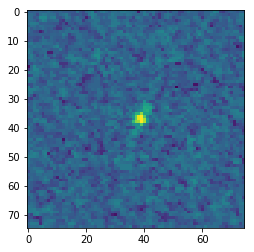

In [3]:
plt.imshow(xTest.iloc[0]['band_2'].reshape(-1, 75))
plt.show()

In [113]:
class DoubleNet(nn.Module):
    
    def __init__(self):
        super(DoubleNet, self).__init__()
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Input 1 branch
        self.input1_layer1_conv2d = nn.Conv2d(in_channels=1, out_channels=8,  kernel_size=7, padding=5)
        self.input1_layer2_conv2d = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, padding=3)
        self.input1_layer3_conv2d = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.input1_layer4_fc = nn.Linear(in_features=3200, out_features=512)
        
        # Input 2 branch
        self.input2_layer1_conv2d = nn.Conv2d(in_channels=1, out_channels=8,  kernel_size=7, padding=5)
        self.input2_layer2_conv2d = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, padding=3)
        self.input2_layer3_conv2d = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.input2_layer4_fc = nn.Linear(in_features=3200, out_features=512)
        
        # Input 3 branch "inc_angle"
        self.input3_layer1_fc1 = nn.Linear(in_features=2, out_features=24)
        
        # Concatenated branch, fully connected stream
        self.fc1 = nn.Linear(in_features=1048, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=512)
        self.fc3 = nn.Linear(in_features=512, out_features=1)
        
    def forward(self, input1, input2, input3):
        
        input1 = self.pool(F.relu(self.input1_layer1_conv2d(input1)))
        input1 = self.pool(F.relu(self.input1_layer2_conv2d(input1)))
        input1 = self.pool(F.relu(self.input1_layer3_conv2d(input1)))
        input1 = F.relu(self.input1_layer4_fc(input1.view(-1, 3200)))
        
        input2 = self.pool(F.relu(self.input2_layer1_conv2d(input2)))
        input2 = self.pool(F.relu(self.input2_layer2_conv2d(input2)))
        input2 = self.pool(F.relu(self.input2_layer3_conv2d(input2)))
        input2 = F.relu(self.input2_layer4_fc(input2.view(-1, 3200)))
        
        input3 = self.input3_layer1_fc1(input3)
        
        combined = torch.cat((input1, input2, input3), 1)
        
        combined = (self.fc1(combined))
        combined = (self.fc2(combined))
        combined = F.sigmoid(self.fc3(combined))
        
        return combined

DoubleNet()

DoubleNet (
  (pool): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (input1_layer1_conv2d): Conv2d(1, 8, kernel_size=(7, 7), stride=(1, 1), padding=(5, 5))
  (input1_layer2_conv2d): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(3, 3))
  (input1_layer3_conv2d): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (input1_layer4_fc): Linear (3200 -> 512)
  (input2_layer1_conv2d): Conv2d(1, 8, kernel_size=(7, 7), stride=(1, 1), padding=(5, 5))
  (input2_layer2_conv2d): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(3, 3))
  (input2_layer3_conv2d): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (input2_layer4_fc): Linear (3200 -> 512)
  (input3_layer1_fc1): Linear (2 -> 24)
  (fc1): Linear (1048 -> 512)
  (fc2): Linear (512 -> 512)
  (fc3): Linear (512 -> 1)
)

In [125]:
print('transfering to cuda')
print('initializing model')
net = DoubleNet()
net.cuda()

n_epoch = 35
batch_size = 300

print('defining optimizers')
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.BCELoss()

# Test data setup
print('concatenated test data')
testBand1 = np.concatenate(xTest.iloc[:]['band_1'].values, axis=0).reshape(-1, 1, 75, 75)
testBand2 = np.concatenate(xTest.iloc[:]['band_2'].values, axis=0).reshape(-1, 1, 75, 75)
testAngle = xTest.iloc[:][['inc_angle', 'inc_angle_was_null']].values.reshape(-1, 2)

print('test data to variables')
testBand1 = Variable(torch.FloatTensor(testBand1).cuda(), requires_grad=False)
testBand2 = Variable(torch.FloatTensor(testBand2).cuda(), requires_grad=False)
testAngle = Variable(torch.FloatTensor(testAngle).cuda(), requires_grad=False)

print('starting training')
for epoch in range(n_epoch):
    
    for sample in (np.random.randint(0, xTrain.shape[0], size=batch_size) 
                   for i in range(0, int(xTrain.shape[0] / batch_size))):
        
        band1 = np.concatenate(xTrain.iloc[sample]['band_1'].values, axis=0).reshape(-1, 1, 75, 75,)
        band2 = np.concatenate(xTrain.iloc[sample]['band_2'].values, axis=0).reshape(-1, 1, 75, 75,)
        angle = xTrain.iloc[sample][['inc_angle', 'inc_angle_was_null']].values.reshape(-1, 2)

        band1 = Variable(torch.FloatTensor(band1).cuda())
        band2 = Variable(torch.FloatTensor(band2).cuda())
        angle = Variable(torch.FloatTensor(angle).cuda())
        target = Variable(torch.FloatTensor(yTrain.iloc[sample].values.astype(float).reshape(-1, 1)).cuda())

        # batch step
        optimizer.zero_grad()

        out = net(band1, band2, angle)
        loss = criterion(out, target)
        loss.backward()

        optimizer.step()
    
    print('Epoch: {} - Loss: {:.6f}'.format(epoch+1, loss.data.cpu().numpy()[0]))
    

transfering to cuda
initializing model
defining optimizers
concatenated test data
test data to variables
starting training
Epoch: 1 - Loss: 2.076000
Epoch: 2 - Loss: 1.196142
Epoch: 3 - Loss: 0.870083
Epoch: 4 - Loss: 0.740674
Epoch: 5 - Loss: 0.708482
Epoch: 6 - Loss: 0.672659
Epoch: 7 - Loss: 0.705477
Epoch: 8 - Loss: 0.612550
Epoch: 9 - Loss: 0.614219
Epoch: 10 - Loss: 0.582758
Epoch: 11 - Loss: 0.553874
Epoch: 12 - Loss: 0.587189
Epoch: 13 - Loss: 0.597466
Epoch: 14 - Loss: 0.553963
Epoch: 15 - Loss: 0.563541
Epoch: 16 - Loss: 0.515052
Epoch: 17 - Loss: 0.549819
Epoch: 18 - Loss: 0.484234
Epoch: 19 - Loss: 0.501610
Epoch: 20 - Loss: 0.550184
Epoch: 21 - Loss: 0.446855
Epoch: 22 - Loss: 0.421391
Epoch: 23 - Loss: 0.551787
Epoch: 24 - Loss: 0.395196
Epoch: 25 - Loss: 0.413363
Epoch: 26 - Loss: 0.386812
Epoch: 27 - Loss: 0.402467
Epoch: 28 - Loss: 0.313353
Epoch: 29 - Loss: 0.382273
Epoch: 30 - Loss: 0.321432
Epoch: 31 - Loss: 0.267831
Epoch: 32 - Loss: 0.363179
Epoch: 33 - Loss: 0.24

In [126]:
# Check score of testing set
from sklearn.metrics import log_loss

pred = net(testBand1, testBand2, testAngle).data.cpu().numpy().squeeze()

print(pred[:10])
log_loss(yTest, pred, )

[  8.10688734e-01   9.78571117e-01   4.79852649e-13   2.29496986e-01
   7.57992625e-01   1.05010255e-25   4.22547273e-02   9.87084687e-01
   3.90100852e-02   5.29151618e-01]


0.33689655363859888

In [127]:
pred[:10]

array([  8.10688734e-01,   9.78571117e-01,   4.79852649e-13,
         2.29496986e-01,   7.57992625e-01,   1.05010255e-25,
         4.22547273e-02,   9.87084687e-01,   3.90100852e-02,
         5.29151618e-01], dtype=float32)

In [112]:
# network layer trials
input1_layer1_conv2d = nn.Conv2d(in_channels=1, out_channels=8,  kernel_size=7, padding=5)
input1_layer2_conv2d = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, padding=3)
input1_layer3_conv2d = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)

fc1 = nn.Linear(in_features=3200, out_features=512)
pool = nn.MaxPool2d(kernel_size=2, stride=2)

pics = np.concatenate(xTest.iloc[0:2]['band_2'].values, axis=0).reshape(-1, 1, 75, 75,)
pics = torch.FloatTensor(pics)
pics = Variable(pics)

pics = pool(input1_layer1_conv2d(pics))
pics = pool(input1_layer2_conv2d(pics))
pics = pool(input1_layer3_conv2d(pics))
print(pics.size())
print(np.prod(pics.size()[1:]))

fc1(pics.view(-1, 3200))

torch.Size([2, 32, 10, 10])
3200


Variable containing:
 2.3612 -1.6764  0.6856  ...   1.2746 -0.7021  0.0448
 2.2727 -1.8845  0.5845  ...   1.0592 -0.7833  0.0286
[torch.FloatTensor of size 2x512]